In [1]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils
from tensorflow.keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Загружаем данные

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
batch_size = 128 # Размер мини-выборки
classes = 10 # Количество классов изображений
epochs = 10 # Количество эпох для обучения
img_rows, img_cols = 32, 32 # Размер изображений
img_channels = 3 # Количество каналов в изображении: RGB
learning_rate = 0.1 # Параметр скорости обучения

In [5]:
# Преобразование размерности изображений
x_train = x_train.reshape(50000, 3072)
x_test = x_test.reshape(10000, 3072)

In [6]:
# Нормализуем данные
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [7]:
# Преобразуем метки в категории
y_train = utils.to_categorical(y_train, classes)
y_test = utils.to_categorical(y_test, classes)

### Создаём модель

In [8]:
# Создаем последовательную модель
model = Sequential()

In [9]:
# Добавляем уровни сети
model.add(Dense(512, activation='relu', input_shape=(3072,) ))
model.add(Dense(10, activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [10]:
# Компилируем модель
sgd = SGD(lr=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics = ["accuracy"])

In [11]:
# Структура сети
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               1573376   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 1,578,506
Trainable params: 1,578,506
Non-trainable params: 0
_________________________________________________________________
None


### Обучаем модель

In [12]:
# Обучаем сеть
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, shuffle = True, verbose=1)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 4s 89us/sample - loss: 2.0272 - acc: 0.2770 - val_loss: 2.0978 - val_acc: 0.2434
Epoch 2/10
40000/40000 [==============================] - 3s 71us/sample - loss: 1.8012 - acc: 0.3559 - val_loss: 1.7576 - val_acc: 0.3798
Epoch 3/10
40000/40000 [==============================] - 3s 74us/sample - loss: 1.7286 - acc: 0.3835 - val_loss: 1.6739 - val_acc: 0.4105
Epoch 4/10
40000/40000 [==============================] - 3s 74us/sample - loss: 1.6721 - acc: 0.4041 - val_loss: 1.6550 - val_acc: 0.4160
Epoch 5/10
40000/40000 [==============================] - 3s 65us/sample - loss: 1.6336 - acc: 0.4200 - val_loss: 1.7141 - val_acc: 0.3792
Epoch 6/10
40000/40000 [==============================] - 3s 65us/sample - loss: 1.5877 - acc: 0.4355 - val_loss: 1.6896 - val_acc: 0.4034
Epoch 7/10
40000/40000 [==============================] - 3s 68us/sample - loss: 1.5639 - acc: 0.4453 - val_loss: 1.

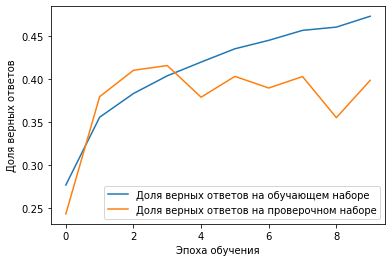

In [13]:
plt.plot(history.history['acc'], label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_acc'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

### Запускаем на тестовых данных

In [14]:
# Оцениваем качество обучения сети на тестовых данных
scores = model.evaluate(x_test, y_test, verbose=0)
print("Точность работы на тестовых данных: %.2f%%" % (scores[1]*100))

Точность работы на тестовых данных: 40.53%
